In [318]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.utils.data.dataloader as Data
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset,DataLoader
import sys
from tqdm import tqdm
import math

In [319]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [320]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [321]:
#Myscore function
def myScore(target, pred):
    print('target', target.shape)
    print('pred', pred.shape)
    Er = 100 * ((target - pred) / target)
    print(Er.shape)
    A = math.exp(-np.log(0.5) * (Er / 5)) if Er <=0 else math.exp(np.log(0.5) * (Er / 20))
    return A

In [322]:
def RMSE(target, pred):
    square_error = (target - pred) ** 2
    mse =  (torch.sum(square_error)) / len(target)
    rmse = mse ** 0.5
    return rmse

In [323]:
def MAE(target, pred):
    absolute_error = np.abs(target - pred)
    return torch.sum(absolute_error) / len(target)

In [324]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
FOLDER = 'Bearing1_1'

In [325]:
X_train_1 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_1 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_2'
X_train_2 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_2 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_4'
X_train_3 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_3 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_3'
# Y_train = Y_train.transpose()
X_test = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_test_X.npy')
Y_test = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_test_Y.npy')

In [326]:
Y_train_1 = np.reshape(Y_train_1, (len(Y_train_1), -1))
Y_train_2 = np.reshape(Y_train_2, (len(Y_train_2), -1))
Y_train_3 = np.reshape(Y_train_3, (len(Y_train_3), -1))
Y_test = np.reshape(Y_test, (len(Y_test), -1))

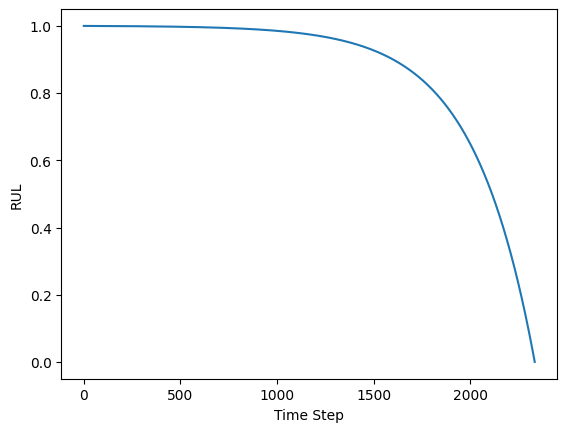

In [327]:
plt.plot(Y_test)
plt.xlabel('Time Step')
plt.ylabel('RUL')
plt.show()

In [328]:
X_train = np.concatenate((X_train_1, X_train_2, X_train_3), axis=0)
Y_train = np.concatenate((Y_train_1, Y_train_2, Y_train_3), axis=0)

In [329]:
# X_np = np.load(f'../../../data/10FEMTO/processed_data/simple_data_X.npy')
# Y_np = np.load(f'../../../data/10FEMTO/processed_data/simple_data_Y.npy')
# X_train, X_test = X_train[:1600], X_test[:1600]
# Y_train, Y_test = Y_np[:1600], Y_np[:1600]
# Y_test = np.reshape(Y_test, (len(Y_test), -1))

In [330]:
X_train = Variable(torch.Tensor(X_train).float())
Y_train = Variable(torch.Tensor(Y_train).float())
X_test = Variable(torch.Tensor(X_test).float())
Y_test = Variable(torch.Tensor(Y_test).float())

In [331]:
#Hyperparameters
FEATURE = 16
EMBEDD = 20
batch_size = 256
dim_val = FEATURE
dim_attn = EMBEDD
dim_val_t = FEATURE
dim_attn_t = EMBEDD
dim_val_s = FEATURE
dim_attn_s = EMBEDD
n_heads = 4
n_decoder_layers = 1
n_encoder_layers = 2
lr = 1e-3
epochs = 100
time_step = 40
dec_seq_len = 4
output_sequence_length = 1
input_size = 16

In [332]:
train_dataset = TensorDataset(X_train,Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size = batch_size,shuffle=False)
test_dataset = TensorDataset(X_test,Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size = batch_size,shuffle=False)

In [333]:
# Initialize model parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# debug = True
debug = False
model = DAST(dim_val_s,dim_attn_s,dim_val_t,dim_attn_t,dim_val, dim_attn,time_step,input_size,dec_seq_len,output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, debug)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [334]:
loss_list = []
train_loss_list = []
test_loss_list = []
train_time = []
test_time = []
best_mse_loss = 10000.0
best_predict = []

In [335]:
for epoch in range(epochs):
    #training
    model.train()
    loop = tqdm(train_loader, leave=True)
    for i,(X, Y) in enumerate(loop):
        batch_X = X.to(device)
        batch_Y = Y.to(device)
        out = model(batch_X)
        loss = criterion(out, batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    loss_eopch = np.mean(np.array(loss_list))
    train_loss_list.append(loss_eopch)
    print('epoch = ',epoch,
            'train_loss = ',loss_eopch.item())

    #testing
    model.eval()
    prediction_list = []
    with torch.no_grad():
        for j ,(batch_x,batch_y) in enumerate(test_loader):
            batch_X = batch_x.to(device)
            batch_Y = batch_y.to(device)
            prediction = model(batch_X)
            # prediction[prediction<0] = 0
            prediction_list.append(prediction)

    out_batch_pre = torch.cat(prediction_list).detach().cpu()
    # prediction_tensor = torch.from_numpy(out_batch_pre)
    rmse_loss = RMSE(Y_test, out_batch_pre, )
    mae_loss = MAE(Y_test, out_batch_pre, )
    test_loss = criterion(out_batch_pre, Y_test)
    test_loss_list.append(test_loss)
    if (test_loss.item() < best_mse_loss):
        best_mse_loss = test_loss.item()
        best_predict = np.reshape(out_batch_pre, (-1)).tolist()
    print('rmse_loss = ', rmse_loss.item(),
            'mae_loss = ', mae_loss.item(),
            'mse_loss = ', test_loss.item())

100%|██████████| 20/20 [00:00<00:00, 21.26it/s]


epoch =  0 train_loss =  0.2749629025674949
rmse_loss =  0.22931355237960815 mae_loss =  0.18842865526676178 mse_loss =  0.052584707736968994


100%|██████████| 20/20 [00:00<00:00, 22.31it/s]


epoch =  1 train_loss =  0.16205271442195227
rmse_loss =  0.2217562049627304 mae_loss =  0.12273547798395157 mse_loss =  0.04917581379413605


100%|██████████| 20/20 [00:00<00:00, 21.71it/s]


epoch =  2 train_loss =  0.11962765271916093
rmse_loss =  0.19501368701457977 mae_loss =  0.13987769186496735 mse_loss =  0.038030337542295456


100%|██████████| 20/20 [00:00<00:00, 22.13it/s]


epoch =  3 train_loss =  0.0990018738202707
rmse_loss =  0.18790985643863678 mae_loss =  0.1364825814962387 mse_loss =  0.035310111939907074


100%|██████████| 20/20 [00:00<00:00, 23.17it/s]


epoch =  4 train_loss =  0.08617947307022406
rmse_loss =  0.18099302053451538 mae_loss =  0.12835480272769928 mse_loss =  0.032758474349975586


100%|██████████| 20/20 [00:00<00:00, 22.59it/s]


epoch =  5 train_loss =  0.07774658488160639
rmse_loss =  0.1781393587589264 mae_loss =  0.13733883202075958 mse_loss =  0.03173363208770752


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


epoch =  6 train_loss =  0.07140954901083855
rmse_loss =  0.17178085446357727 mae_loss =  0.12892435491085052 mse_loss =  0.02950866147875786


100%|██████████| 20/20 [00:00<00:00, 21.56it/s]


epoch =  7 train_loss =  0.06619956068652755
rmse_loss =  0.1600004881620407 mae_loss =  0.11082849651575089 mse_loss =  0.02560015395283699


100%|██████████| 20/20 [00:00<00:00, 22.10it/s]


epoch =  8 train_loss =  0.06191644532656129
rmse_loss =  0.15178070962429047 mae_loss =  0.10521430522203445 mse_loss =  0.02303738333284855


100%|██████████| 20/20 [00:00<00:00, 40.31it/s]


epoch =  9 train_loss =  0.0583408484330721
rmse_loss =  0.1461849957704544 mae_loss =  0.10360368341207504 mse_loss =  0.0213700532913208


100%|██████████| 20/20 [00:00<00:00, 41.96it/s]


epoch =  10 train_loss =  0.05527090932929158
rmse_loss =  0.1402522623538971 mae_loss =  0.09978737682104111 mse_loss =  0.019670695066452026


100%|██████████| 20/20 [00:00<00:00, 41.95it/s]


epoch =  11 train_loss =  0.05266097498940023
rmse_loss =  0.13885101675987244 mae_loss =  0.10295221954584122 mse_loss =  0.01927960477769375


100%|██████████| 20/20 [00:00<00:00, 41.99it/s]


epoch =  12 train_loss =  0.050389007605274226
rmse_loss =  0.1381029635667801 mae_loss =  0.10710462182760239 mse_loss =  0.019072430208325386


100%|██████████| 20/20 [00:00<00:00, 41.97it/s]


epoch =  13 train_loss =  0.04845569150540022
rmse_loss =  0.14470133185386658 mae_loss =  0.1186460331082344 mse_loss =  0.02093847468495369


100%|██████████| 20/20 [00:00<00:00, 41.99it/s]


epoch =  14 train_loss =  0.046903934556224464
rmse_loss =  0.1518494039773941 mae_loss =  0.1288883239030838 mse_loss =  0.023058243095874786


100%|██████████| 20/20 [00:00<00:00, 42.01it/s]


epoch =  15 train_loss =  0.04552469682971605
rmse_loss =  0.15764079988002777 mae_loss =  0.13622134923934937 mse_loss =  0.024850623682141304


100%|██████████| 20/20 [00:00<00:00, 42.01it/s]


epoch =  16 train_loss =  0.04439086297407972
rmse_loss =  0.14900532364845276 mae_loss =  0.1247037872672081 mse_loss =  0.022202586755156517


100%|██████████| 20/20 [00:00<00:00, 22.98it/s]


epoch =  17 train_loss =  0.043320862193528833
rmse_loss =  0.13295850157737732 mae_loss =  0.09958682954311371 mse_loss =  0.01767796464264393


100%|██████████| 20/20 [00:00<00:00, 22.75it/s]


epoch =  18 train_loss =  0.042221578396282364
rmse_loss =  0.12299694120883942 mae_loss =  0.07898961752653122 mse_loss =  0.015128248371183872


100%|██████████| 20/20 [00:00<00:00, 22.28it/s]


epoch =  19 train_loss =  0.04109368256857124
rmse_loss =  0.12294419854879379 mae_loss =  0.07830401510000229 mse_loss =  0.015115275047719479


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]


epoch =  20 train_loss =  0.040049581919620755
rmse_loss =  0.12615036964416504 mae_loss =  0.08145749568939209 mse_loss =  0.015913916751742363


100%|██████████| 20/20 [00:00<00:00, 21.13it/s]


epoch =  21 train_loss =  0.03907398952095801
rmse_loss =  0.1370832920074463 mae_loss =  0.09155039489269257 mse_loss =  0.01879183016717434


100%|██████████| 20/20 [00:00<00:00, 22.17it/s]


epoch =  22 train_loss =  0.038472167359229745
rmse_loss =  0.13347215950489044 mae_loss =  0.09105531126260757 mse_loss =  0.017814816907048225


100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


epoch =  23 train_loss =  0.03811629462494845
rmse_loss =  0.15236827731132507 mae_loss =  0.12179986387491226 mse_loss =  0.023216091096401215


100%|██████████| 20/20 [00:00<00:00, 21.29it/s]


epoch =  24 train_loss =  0.037861386945587584
rmse_loss =  0.11006183177232742 mae_loss =  0.062188707292079926 mse_loss =  0.012113606557250023


100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


epoch =  25 train_loss =  0.03717103363039943
rmse_loss =  0.10517363995313644 mae_loss =  0.06258682906627655 mse_loss =  0.01106149423867464


100%|██████████| 20/20 [00:00<00:00, 21.54it/s]


epoch =  26 train_loss =  0.03642222501954098
rmse_loss =  0.12032235413789749 mae_loss =  0.07461424916982651 mse_loss =  0.014477469027042389


100%|██████████| 20/20 [00:00<00:00, 22.01it/s]


epoch =  27 train_loss =  0.035735241986965
rmse_loss =  0.1288047879934311 mae_loss =  0.07737351208925247 mse_loss =  0.016590671613812447


100%|██████████| 20/20 [00:00<00:00, 22.75it/s]


epoch =  28 train_loss =  0.035084864834989904
rmse_loss =  0.1236884817481041 mae_loss =  0.06938090175390244 mse_loss =  0.015298840589821339


100%|██████████| 20/20 [00:00<00:00, 22.24it/s]


epoch =  29 train_loss =  0.03445239496368837
rmse_loss =  0.14298634231090546 mae_loss =  0.0814252644777298 mse_loss =  0.020445095375180244


100%|██████████| 20/20 [00:00<00:00, 20.99it/s]


epoch =  30 train_loss =  0.03383801175263098
rmse_loss =  0.16514797508716583 mae_loss =  0.09441148489713669 mse_loss =  0.027273856103420258


100%|██████████| 20/20 [00:00<00:00, 22.10it/s]


epoch =  31 train_loss =  0.033261217499375564
rmse_loss =  0.13420724868774414 mae_loss =  0.07437837868928909 mse_loss =  0.018011584877967834


100%|██████████| 20/20 [00:00<00:00, 23.50it/s]


epoch =  32 train_loss =  0.03271308143708721
rmse_loss =  0.15135106444358826 mae_loss =  0.08211597055196762 mse_loss =  0.02290714532136917


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


epoch =  33 train_loss =  0.0321602295153057
rmse_loss =  0.18006590008735657 mae_loss =  0.09923601895570755 mse_loss =  0.032423727214336395


100%|██████████| 20/20 [00:00<00:00, 21.18it/s]


epoch =  34 train_loss =  0.03166507969338064
rmse_loss =  0.11520321667194366 mae_loss =  0.0637403130531311 mse_loss =  0.013271781615912914


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


epoch =  35 train_loss =  0.03130661106760171
rmse_loss =  0.19590862095355988 mae_loss =  0.10905925184488297 mse_loss =  0.03838018700480461


100%|██████████| 20/20 [00:00<00:00, 21.79it/s]


epoch =  36 train_loss =  0.030884900842195476
rmse_loss =  0.18217992782592773 mae_loss =  0.11423836648464203 mse_loss =  0.033189527690410614


100%|██████████| 20/20 [00:00<00:00, 22.21it/s]


epoch =  37 train_loss =  0.030598111709236705
rmse_loss =  0.1138911247253418 mae_loss =  0.06540373712778091 mse_loss =  0.012971187941730022


100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


epoch =  38 train_loss =  0.030349861521823094
rmse_loss =  0.1956726610660553 mae_loss =  0.11861201375722885 mse_loss =  0.03828779235482216


100%|██████████| 20/20 [00:00<00:00, 21.95it/s]


epoch =  39 train_loss =  0.030151247060566676
rmse_loss =  0.11801665276288986 mae_loss =  0.07835512608289719 mse_loss =  0.013927930034697056


100%|██████████| 20/20 [00:00<00:00, 21.87it/s]


epoch =  40 train_loss =  0.029883417286478885
rmse_loss =  0.13716430962085724 mae_loss =  0.07735036313533783 mse_loss =  0.018814049661159515


100%|██████████| 20/20 [00:00<00:00, 22.30it/s]


epoch =  41 train_loss =  0.029556879796611958
rmse_loss =  0.10039817541837692 mae_loss =  0.04954115301370621 mse_loss =  0.010079793632030487


100%|██████████| 20/20 [00:00<00:00, 21.79it/s]


epoch =  42 train_loss =  0.02919568977848157
rmse_loss =  0.13377097249031067 mae_loss =  0.07355205714702606 mse_loss =  0.017894674092531204


100%|██████████| 20/20 [00:00<00:00, 21.27it/s]


epoch =  43 train_loss =  0.028829126266224525
rmse_loss =  0.097090944647789 mae_loss =  0.05058752000331879 mse_loss =  0.009426651522517204


100%|██████████| 20/20 [00:00<00:00, 22.26it/s]


epoch =  44 train_loss =  0.028510555592308973
rmse_loss =  0.15119199454784393 mae_loss =  0.08093561232089996 mse_loss =  0.02285901829600334


100%|██████████| 20/20 [00:00<00:00, 22.19it/s]


epoch =  45 train_loss =  0.028198866656123794
rmse_loss =  0.10139810293912888 mae_loss =  0.0553448423743248 mse_loss =  0.010281575843691826


100%|██████████| 20/20 [00:00<00:00, 22.85it/s]


epoch =  46 train_loss =  0.02794923711490868
rmse_loss =  0.1432020515203476 mae_loss =  0.07716484367847443 mse_loss =  0.020506827160716057


100%|██████████| 20/20 [00:00<00:00, 20.90it/s]


epoch =  47 train_loss =  0.027686548268646523
rmse_loss =  0.0957094356417656 mae_loss =  0.051815371960401535 mse_loss =  0.009160296060144901


100%|██████████| 20/20 [00:00<00:00, 21.63it/s]


epoch =  48 train_loss =  0.027429281359389057
rmse_loss =  0.12050940096378326 mae_loss =  0.06554599106311798 mse_loss =  0.01452251523733139


100%|██████████| 20/20 [00:00<00:00, 21.49it/s]


epoch =  49 train_loss =  0.02714385093111923
rmse_loss =  0.08927708119153976 mae_loss =  0.04688053950667381 mse_loss =  0.007970397360622883


100%|██████████| 20/20 [00:00<00:00, 22.77it/s]


epoch =  50 train_loss =  0.026862324726821766
rmse_loss =  0.12078024446964264 mae_loss =  0.0646606832742691 mse_loss =  0.014587868005037308


100%|██████████| 20/20 [00:00<00:00, 22.70it/s]


epoch =  51 train_loss =  0.026576459191661482
rmse_loss =  0.08786158263683319 mae_loss =  0.04723294451832771 mse_loss =  0.007719658315181732


100%|██████████| 20/20 [00:00<00:00, 23.30it/s]


epoch =  52 train_loss =  0.02633082290979147
rmse_loss =  0.13451945781707764 mae_loss =  0.07175791263580322 mse_loss =  0.018095484003424644


100%|██████████| 20/20 [00:00<00:00, 22.87it/s]


epoch =  53 train_loss =  0.026096948057878492
rmse_loss =  0.09183669090270996 mae_loss =  0.050675489008426666 mse_loss =  0.008433977141976357


100%|██████████| 20/20 [00:00<00:00, 22.90it/s]


epoch =  54 train_loss =  0.02589948436601844
rmse_loss =  0.12098664790391922 mae_loss =  0.0646805465221405 mse_loss =  0.01463776919990778


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


epoch =  55 train_loss =  0.025692351485999358
rmse_loss =  0.08537809550762177 mae_loss =  0.0464438870549202 mse_loss =  0.007289419416338205


100%|██████████| 20/20 [00:00<00:00, 22.52it/s]


epoch =  56 train_loss =  0.02546554850490346
rmse_loss =  0.1004716157913208 mae_loss =  0.055909883230924606 mse_loss =  0.010094544850289822


100%|██████████| 20/20 [00:00<00:00, 22.77it/s]


epoch =  57 train_loss =  0.025214027576802092
rmse_loss =  0.07889335602521896 mae_loss =  0.041873373091220856 mse_loss =  0.006224161479622126


100%|██████████| 20/20 [00:00<00:00, 21.44it/s]


epoch =  58 train_loss =  0.024970130246657715
rmse_loss =  0.11488206684589386 mae_loss =  0.06173582375049591 mse_loss =  0.013197888620197773


100%|██████████| 20/20 [00:00<00:00, 23.04it/s]


epoch =  59 train_loss =  0.024737395739981974
rmse_loss =  0.08052939176559448 mae_loss =  0.04395873472094536 mse_loss =  0.006484983488917351


100%|██████████| 20/20 [00:00<00:00, 22.15it/s]


epoch =  60 train_loss =  0.02455869465574339
rmse_loss =  0.13190792500972748 mae_loss =  0.0717541053891182 mse_loss =  0.017399702221155167


100%|██████████| 20/20 [00:00<00:00, 22.89it/s]


epoch =  61 train_loss =  0.024378635754170142
rmse_loss =  0.08516782522201538 mae_loss =  0.04832611232995987 mse_loss =  0.007253557909280062


100%|██████████| 20/20 [00:00<00:00, 21.95it/s]


epoch =  62 train_loss =  0.024199288403969912
rmse_loss =  0.11527460813522339 mae_loss =  0.0631902739405632 mse_loss =  0.013288235291838646


100%|██████████| 20/20 [00:00<00:00, 21.74it/s]


epoch =  63 train_loss =  0.024021801179031854
rmse_loss =  0.0870281308889389 mae_loss =  0.04384280741214752 mse_loss =  0.007573896087706089


100%|██████████| 20/20 [00:00<00:00, 21.37it/s]


epoch =  64 train_loss =  0.02387520080008611
rmse_loss =  0.0974288061261177 mae_loss =  0.05139501392841339 mse_loss =  0.009492372162640095


100%|██████████| 20/20 [00:00<00:00, 22.58it/s]


epoch =  65 train_loss =  0.023699351287486382
rmse_loss =  0.07366535067558289 mae_loss =  0.03959668427705765 mse_loss =  0.005426584277302027


100%|██████████| 20/20 [00:00<00:00, 23.55it/s]


epoch =  66 train_loss =  0.02350694876243582
rmse_loss =  0.08668437600135803 mae_loss =  0.050681475549936295 mse_loss =  0.007514181546866894


100%|██████████| 20/20 [00:00<00:00, 22.08it/s]


epoch =  67 train_loss =  0.02329920935049171
rmse_loss =  0.06957696378231049 mae_loss =  0.036875851452350616 mse_loss =  0.00484095374122262


100%|██████████| 20/20 [00:00<00:00, 22.06it/s]


epoch =  68 train_loss =  0.02310225620607578
rmse_loss =  0.10156193375587463 mae_loss =  0.056485366076231 mse_loss =  0.010314825922250748


100%|██████████| 20/20 [00:00<00:00, 22.92it/s]


epoch =  69 train_loss =  0.022915587070321115
rmse_loss =  0.07123523950576782 mae_loss =  0.039119645953178406 mse_loss =  0.005074459593743086


100%|██████████| 20/20 [00:00<00:00, 21.40it/s]


epoch =  70 train_loss =  0.022735653996375768
rmse_loss =  0.11406144499778748 mae_loss =  0.06435553729534149 mse_loss =  0.013010013848543167


100%|██████████| 20/20 [00:00<00:00, 22.68it/s]


epoch =  71 train_loss =  0.02256934905106694
rmse_loss =  0.08572506904602051 mae_loss =  0.045681100338697433 mse_loss =  0.007348787970840931


100%|██████████| 20/20 [00:00<00:00, 22.26it/s]


epoch =  72 train_loss =  0.022465213822534393
rmse_loss =  0.12082511931657791 mae_loss =  0.06791442632675171 mse_loss =  0.014598709531128407


100%|██████████| 20/20 [00:00<00:00, 20.89it/s]


epoch =  73 train_loss =  0.022345020361796274
rmse_loss =  0.0816803053021431 mae_loss =  0.04359200969338417 mse_loss =  0.006671672686934471


100%|██████████| 20/20 [00:00<00:00, 21.66it/s]


epoch =  74 train_loss =  0.022222980123900924
rmse_loss =  0.08386649936437607 mae_loss =  0.04477531835436821 mse_loss =  0.007033589296042919


100%|██████████| 20/20 [00:00<00:00, 22.94it/s]


epoch =  75 train_loss =  0.0220711226667127
rmse_loss =  0.0649760290980339 mae_loss =  0.03226624056696892 mse_loss =  0.004221884533762932


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]


epoch =  76 train_loss =  0.021912363132981807
rmse_loss =  0.090184286236763 mae_loss =  0.049881502985954285 mse_loss =  0.008133205585181713


100%|██████████| 20/20 [00:00<00:00, 22.87it/s]


epoch =  77 train_loss =  0.02175907938445818
rmse_loss =  0.06985444575548172 mae_loss =  0.036583177745342255 mse_loss =  0.004879643674939871


100%|██████████| 20/20 [00:00<00:00, 23.38it/s]


epoch =  78 train_loss =  0.021629299829685266
rmse_loss =  0.1071564108133316 mae_loss =  0.05859408900141716 mse_loss =  0.011482495814561844


100%|██████████| 20/20 [00:00<00:00, 23.10it/s]


epoch =  79 train_loss =  0.021502954634406705
rmse_loss =  0.07466091215610504 mae_loss =  0.04023704305291176 mse_loss =  0.005574251525104046


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


epoch =  80 train_loss =  0.021368292438534282
rmse_loss =  0.10603812336921692 mae_loss =  0.059464339166879654 mse_loss =  0.011244083754718304


100%|██████████| 20/20 [00:00<00:00, 21.42it/s]


epoch =  81 train_loss =  0.021249109225453405
rmse_loss =  0.1154576987028122 mae_loss =  0.05866611748933792 mse_loss =  0.013330480083823204


100%|██████████| 20/20 [00:00<00:00, 21.80it/s]


epoch =  82 train_loss =  0.021218301399214004
rmse_loss =  0.07457168400287628 mae_loss =  0.05075136944651604 mse_loss =  0.005560936406254768


100%|██████████| 20/20 [00:00<00:00, 22.29it/s]


epoch =  83 train_loss =  0.021103079821897977
rmse_loss =  0.08739568293094635 mae_loss =  0.05157964304089546 mse_loss =  0.007638005074113607


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


epoch =  84 train_loss =  0.020981290836802252
rmse_loss =  0.073823481798172 mae_loss =  0.047516461461782455 mse_loss =  0.005449906922876835


100%|██████████| 20/20 [00:00<00:00, 23.36it/s]


epoch =  85 train_loss =  0.020837791704290665
rmse_loss =  0.11173739284276962 mae_loss =  0.06385615468025208 mse_loss =  0.012485244311392307


100%|██████████| 20/20 [00:00<00:00, 23.02it/s]


epoch =  86 train_loss =  0.020721496461422132
rmse_loss =  0.10593348741531372 mae_loss =  0.05241028219461441 mse_loss =  0.011221903376281261


100%|██████████| 20/20 [00:00<00:00, 21.49it/s]


epoch =  87 train_loss =  0.020676699020999546
rmse_loss =  0.07585891336202621 mae_loss =  0.050103962421417236 mse_loss =  0.005754574667662382


100%|██████████| 20/20 [00:00<00:00, 22.92it/s]


epoch =  88 train_loss =  0.020590390381652612
rmse_loss =  0.0963754802942276 mae_loss =  0.06172025203704834 mse_loss =  0.009288232773542404


100%|██████████| 20/20 [00:00<00:00, 23.84it/s]


epoch =  89 train_loss =  0.020495389097312806
rmse_loss =  0.0711900144815445 mae_loss =  0.051536042243242264 mse_loss =  0.005068018566817045


100%|██████████| 20/20 [00:00<00:00, 22.73it/s]


epoch =  90 train_loss =  0.020402951023013205
rmse_loss =  0.09392345696687698 mae_loss =  0.053028278052806854 mse_loss =  0.00882161594927311


100%|██████████| 20/20 [00:00<00:00, 22.49it/s]


epoch =  91 train_loss =  0.020318306452001073
rmse_loss =  0.1724202185869217 mae_loss =  0.11822383105754852 mse_loss =  0.029728731140494347


100%|██████████| 20/20 [00:00<00:00, 21.62it/s]


epoch =  92 train_loss =  0.020301981083039503
rmse_loss =  0.13986104726791382 mae_loss =  0.07178983837366104 mse_loss =  0.01956111192703247


100%|██████████| 20/20 [00:00<00:00, 21.49it/s]


epoch =  93 train_loss =  0.020331330333683967
rmse_loss =  0.08438865840435028 mae_loss =  0.048947524279356 mse_loss =  0.007121446076780558


100%|██████████| 20/20 [00:00<00:00, 22.12it/s]


epoch =  94 train_loss =  0.020265469172581537
rmse_loss =  0.1388889104127884 mae_loss =  0.10458417236804962 mse_loss =  0.019290130585432053


100%|██████████| 20/20 [00:00<00:00, 22.73it/s]


epoch =  95 train_loss =  0.02023116836710983
rmse_loss =  0.08619841188192368 mae_loss =  0.04973221942782402 mse_loss =  0.007430166006088257


100%|██████████| 20/20 [00:00<00:00, 21.64it/s]


epoch =  96 train_loss =  0.02016437392838683
rmse_loss =  0.08395667374134064 mae_loss =  0.042651720345020294 mse_loss =  0.007048723287880421


100%|██████████| 20/20 [00:00<00:00, 23.13it/s]


epoch =  97 train_loss =  0.020067542595342627
rmse_loss =  0.07455608248710632 mae_loss =  0.04044058173894882 mse_loss =  0.005558609031140804


100%|██████████| 20/20 [00:00<00:00, 21.08it/s]


epoch =  98 train_loss =  0.019966033012517276
rmse_loss =  0.07953210175037384 mae_loss =  0.050679195672273636 mse_loss =  0.006325355265289545


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]

epoch =  99 train_loss =  0.019853321727216097
rmse_loss =  0.10178431123495102 mae_loss =  0.05988454446196556 mse_loss =  0.010360046289861202


In [336]:
print(best_mse_loss)

0.004221884533762932


In [337]:
z = np.reshape(out_batch_pre, (-1))
z = z.tolist()

In [338]:
y = Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

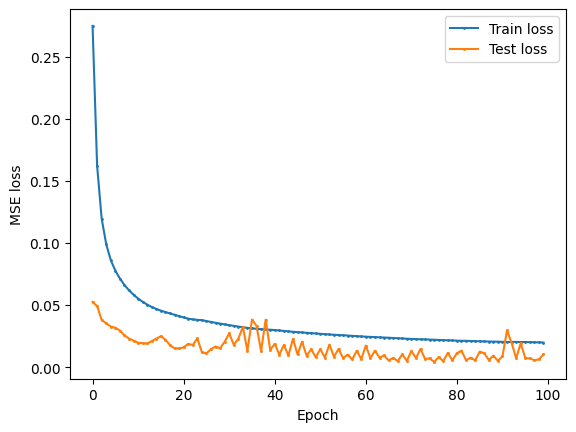

In [339]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(train_loss_list, label='Train loss', marker='o', markersize=1)
plt.plot(test_loss_list, label='Test loss', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
# Adding a legend
plt.legend()

# Display the plot
plt.show()

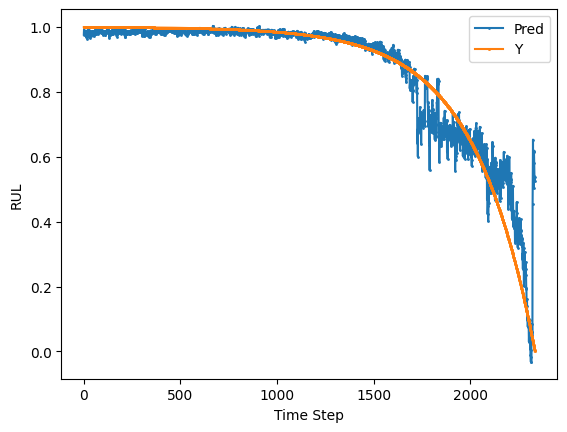

In [340]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(best_predict, label='Pred', marker='o', markersize=1)
plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('RUL')
# Adding a legend
plt.legend()

# Display the plot
plt.show()

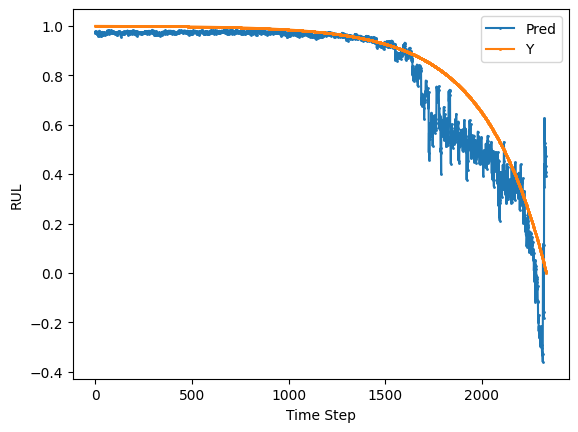

In [341]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(z, label='Pred', marker='o', markersize=1)
plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('RUL')
# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
# run above

# RUN above

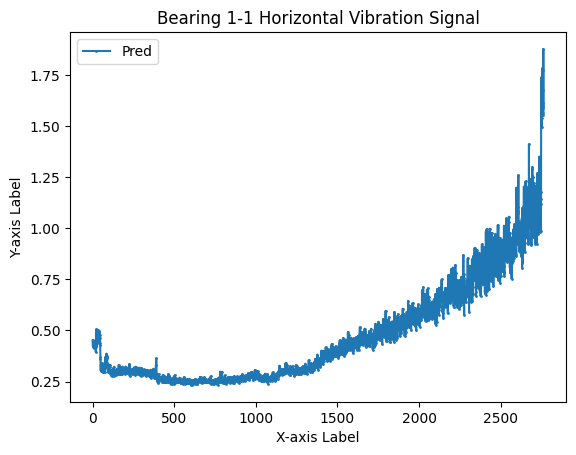

In [22]:
import matplotlib.pyplot as plt
# Example data
X_draw = X_train[:2763, 0, 4]
# Plotting the line chart
plt.plot(X_draw, label='Pred', marker='o', markersize=1)
# plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Bearing 1-1 Horizontal Vibration Signal')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

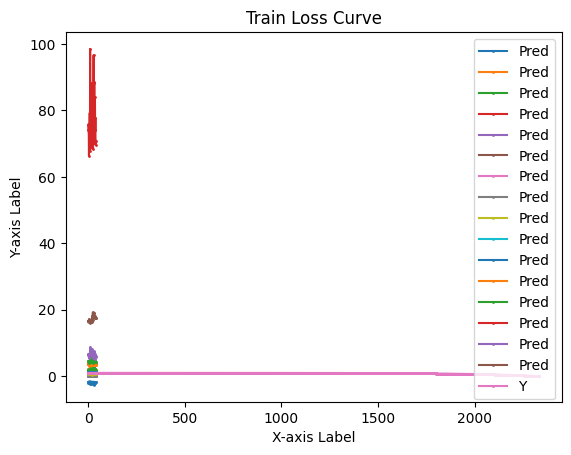

In [23]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_train[0], label='Pred', marker='o', markersize=1)
plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

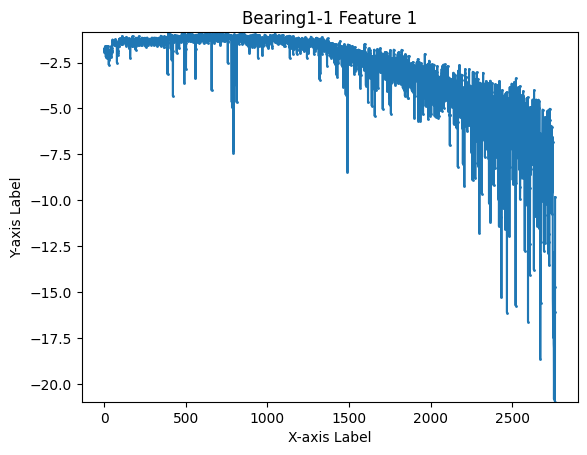

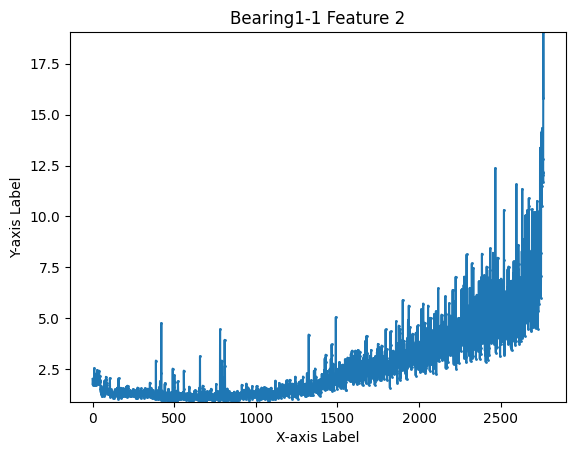

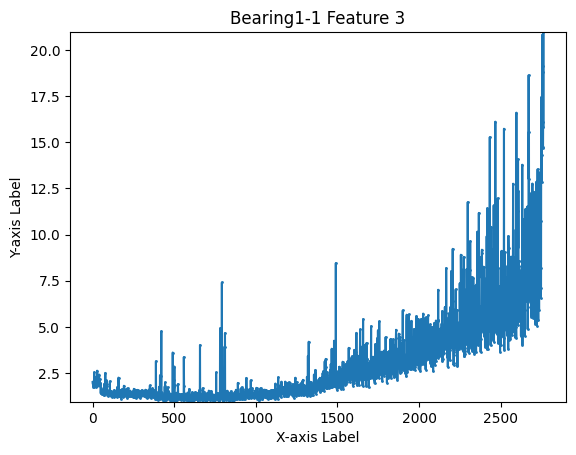

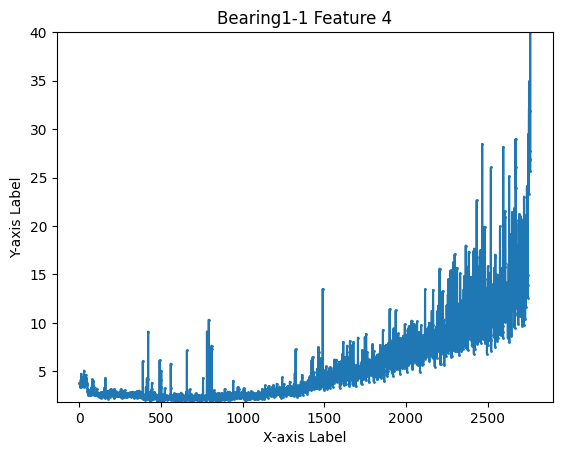

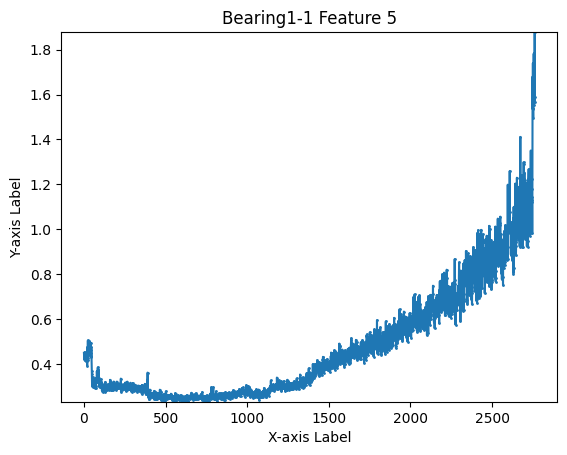

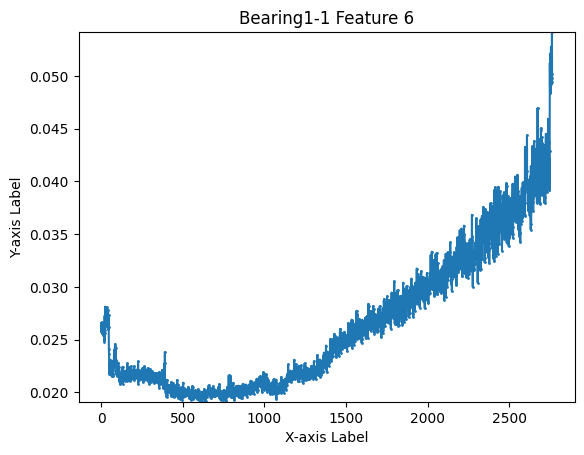

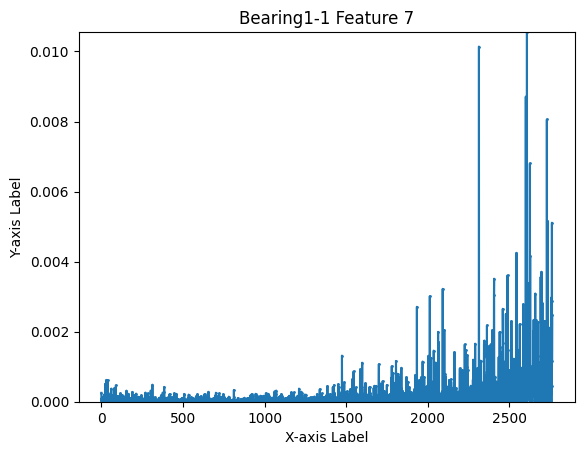

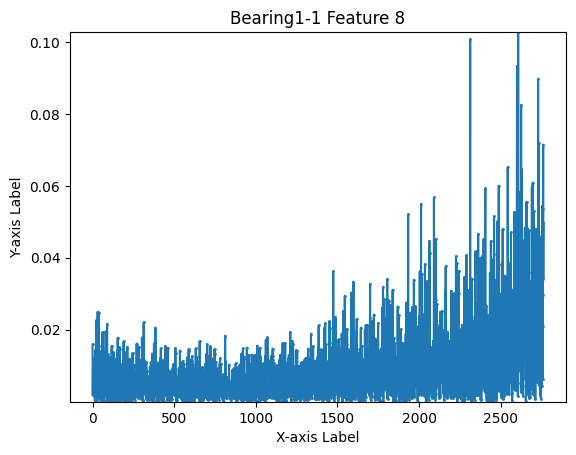

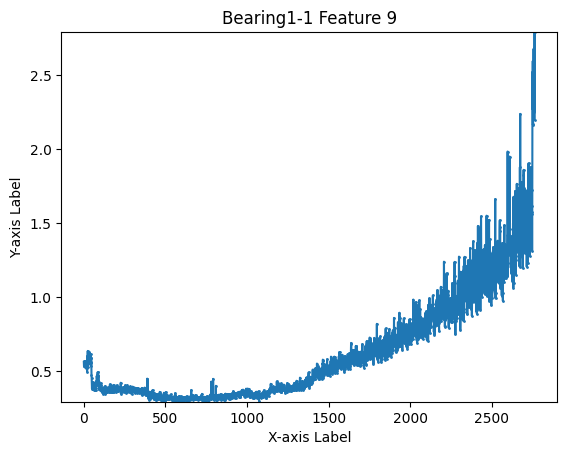

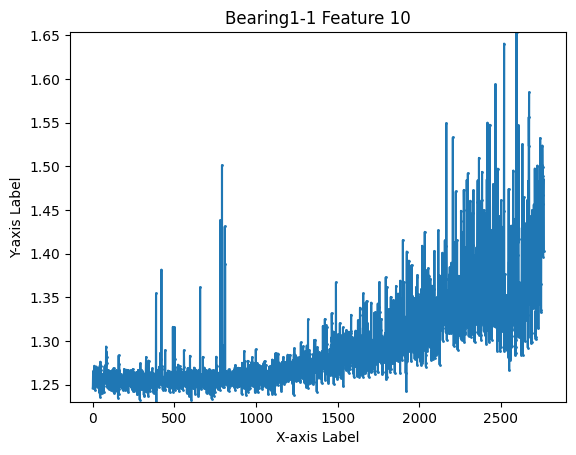

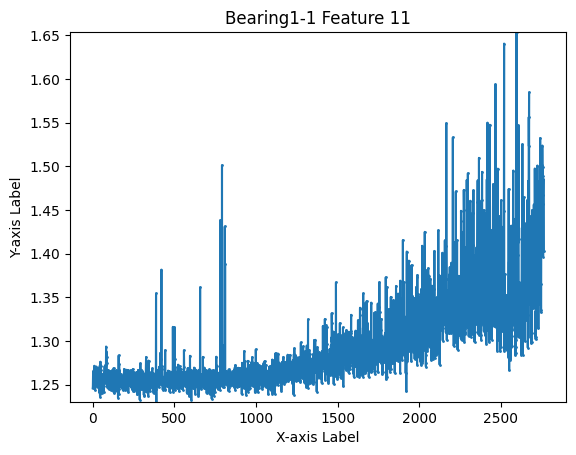

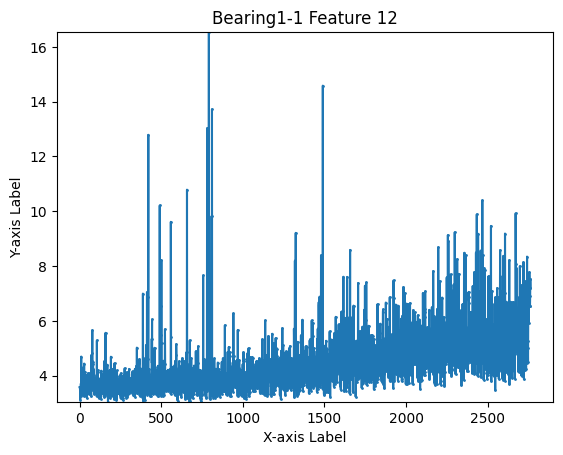

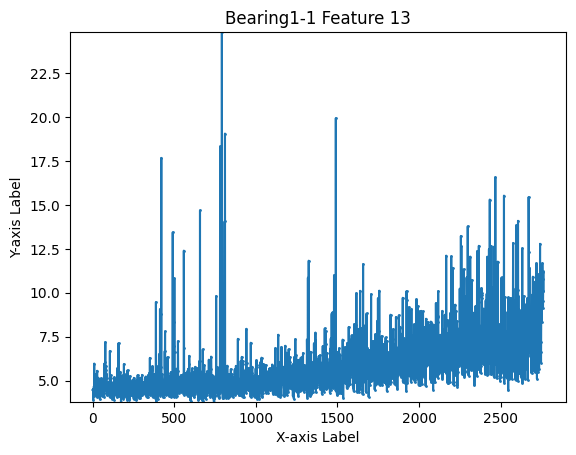

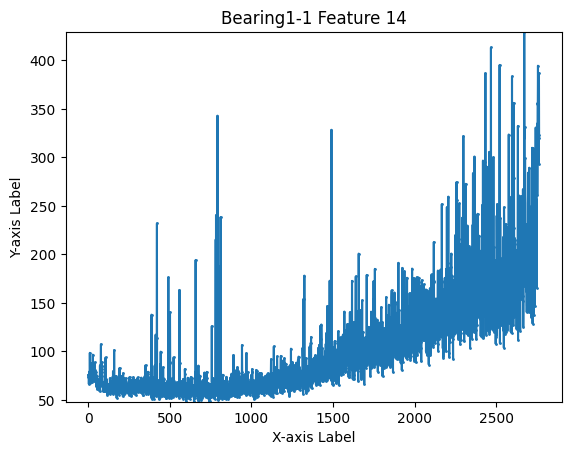

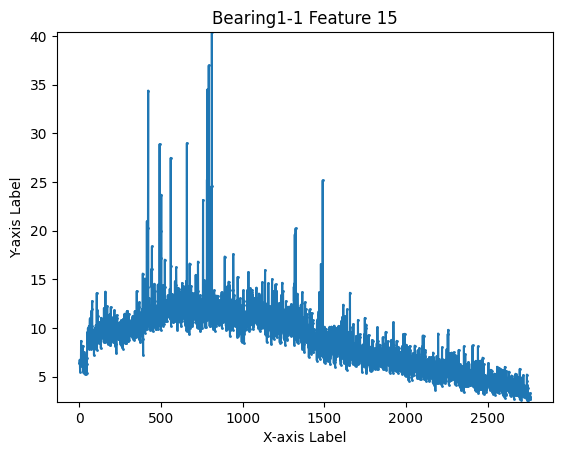

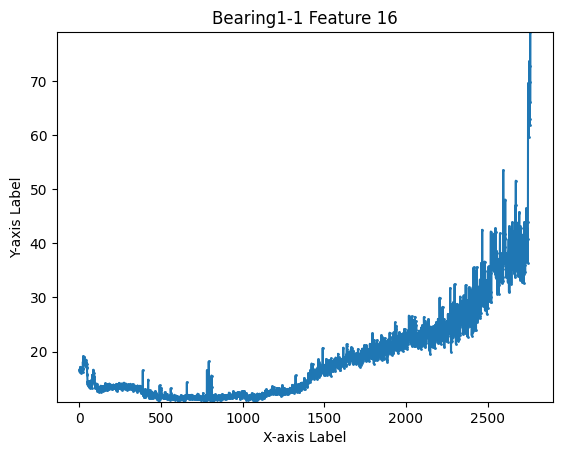

IndexError: index 16 is out of bounds for axis 2 with size 16

In [25]:
import matplotlib.pyplot as plt

for i in range(20):
    plt.plot(X_train_1[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_1[:, 0, i]), max(X_train_1[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-1 Feature {i+1}')
    plt.show()

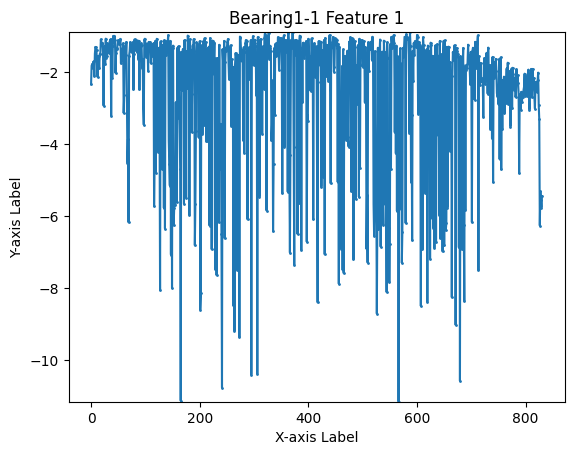

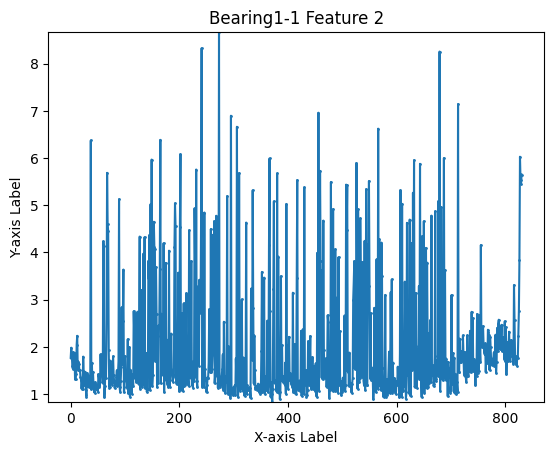

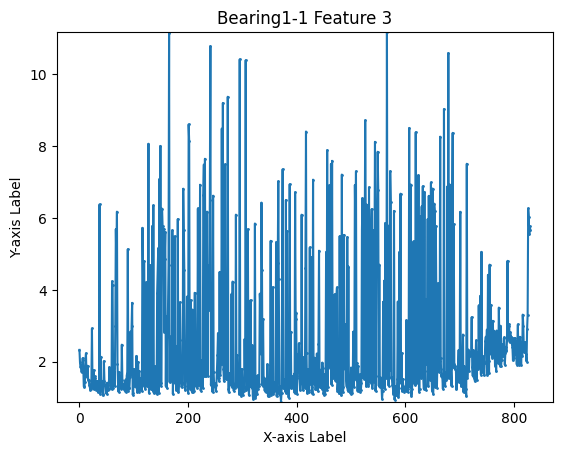

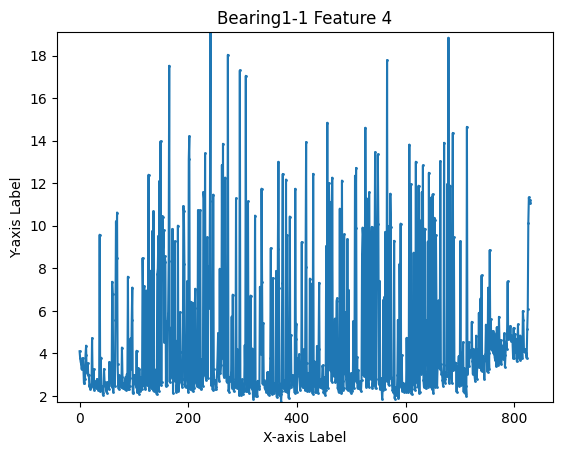

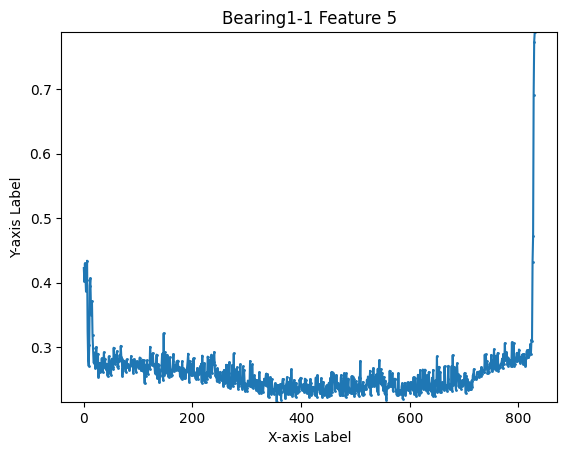

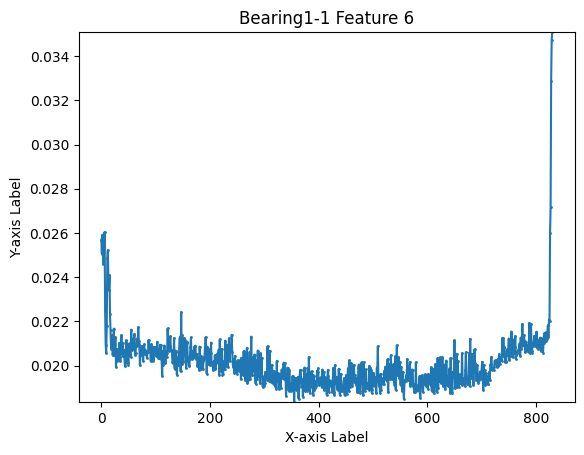

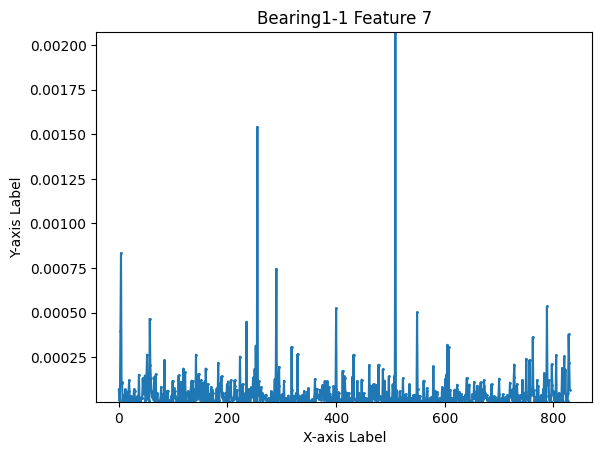

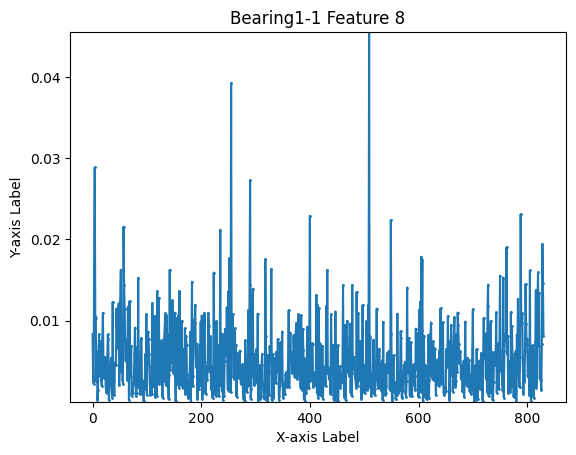

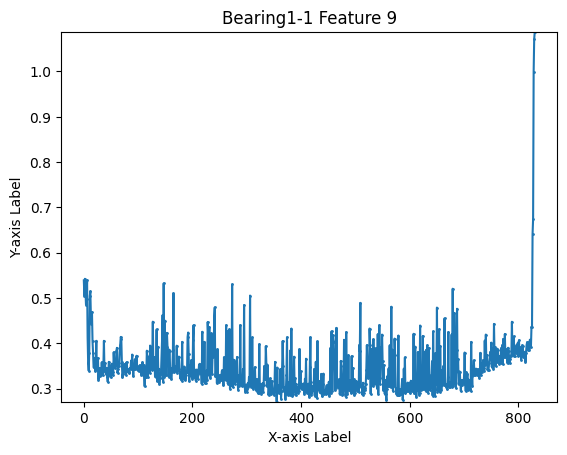

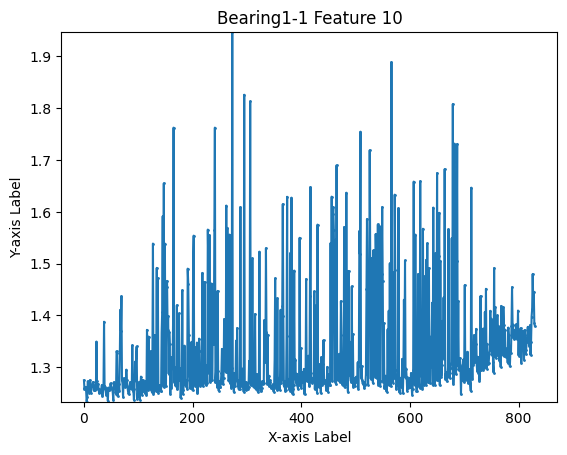

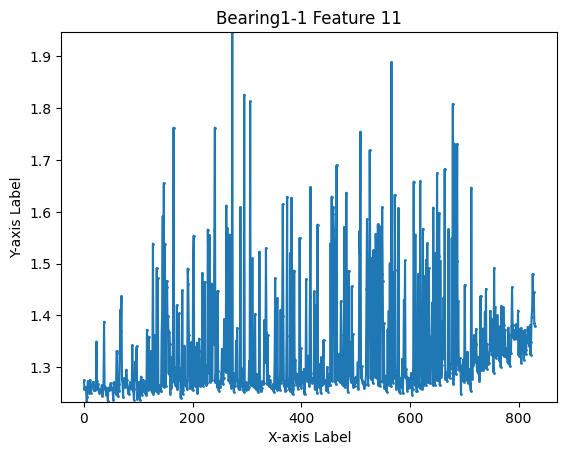

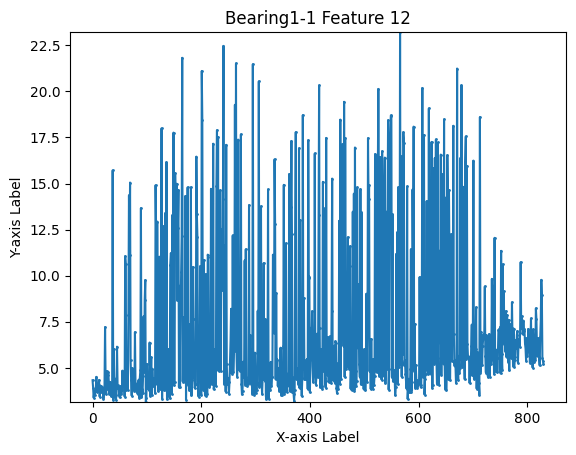

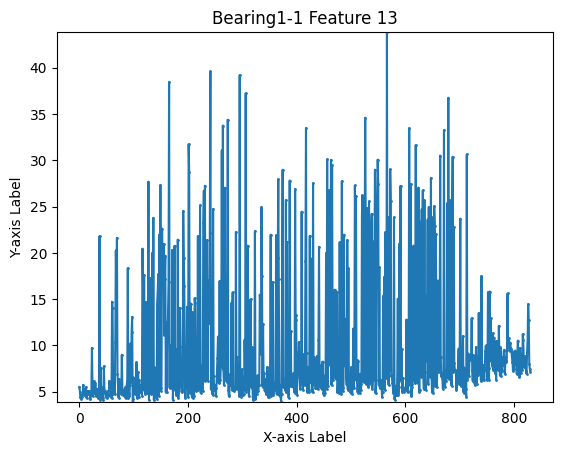

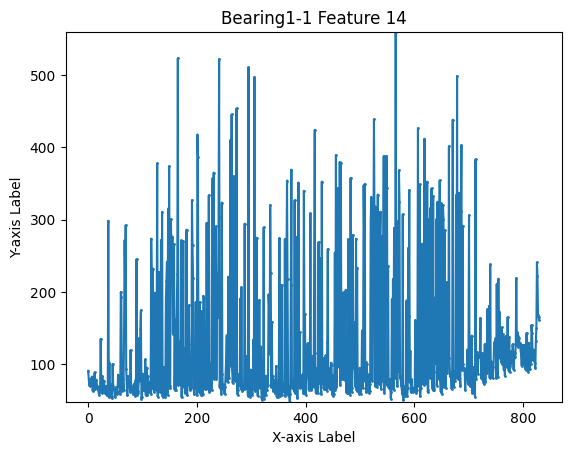

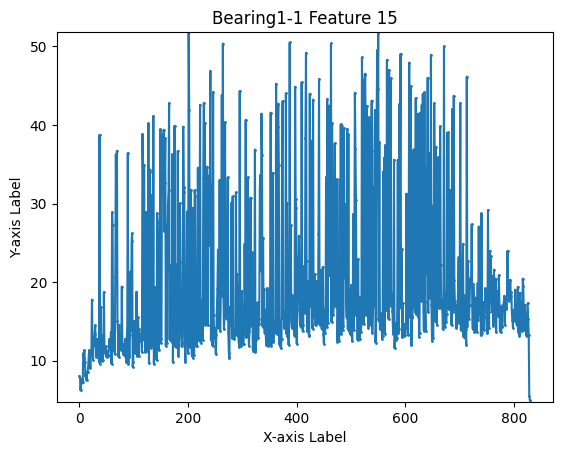

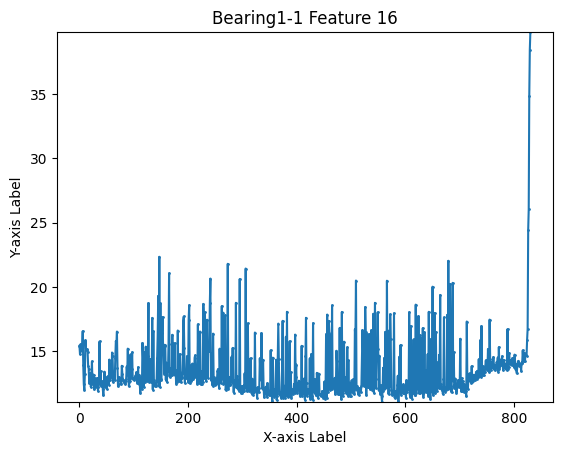

IndexError: index 16 is out of bounds for axis 2 with size 16

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_2[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_2[:, 0, i]), max(X_train_2[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-2 Feature {i+1}')
    # Display the plot
    plt.show()

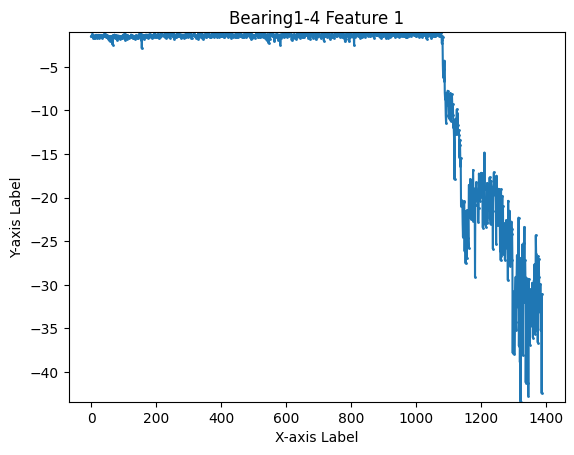

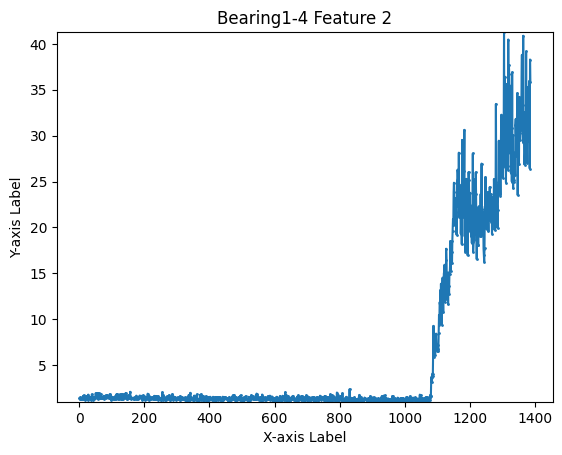

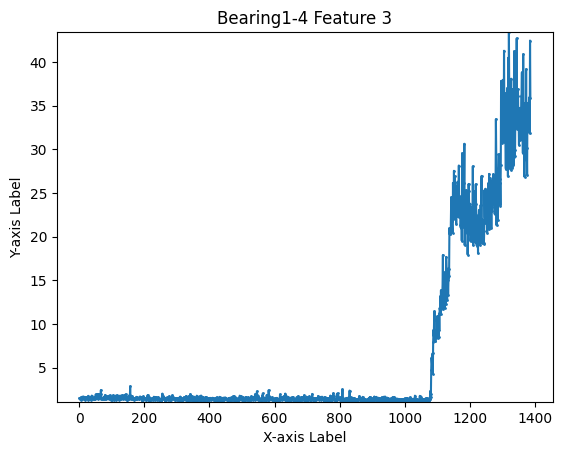

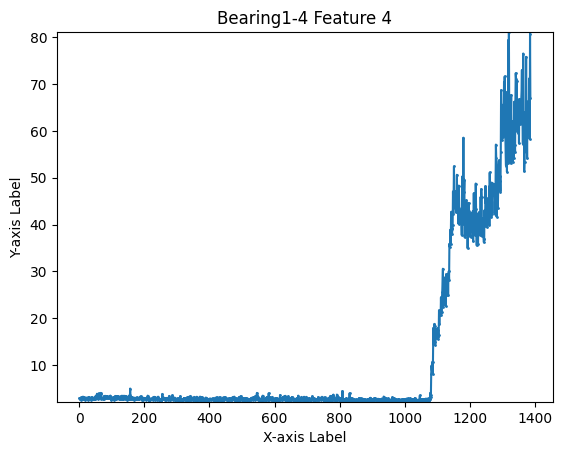

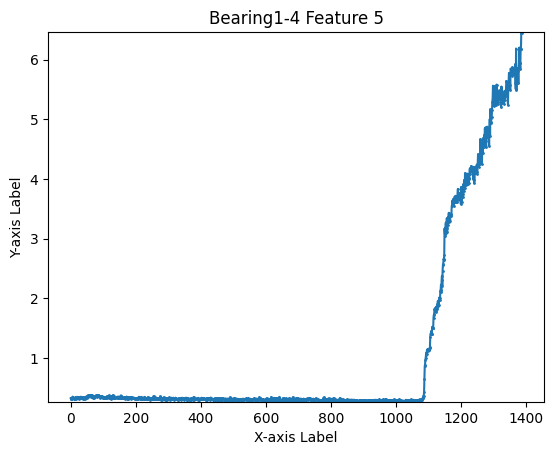

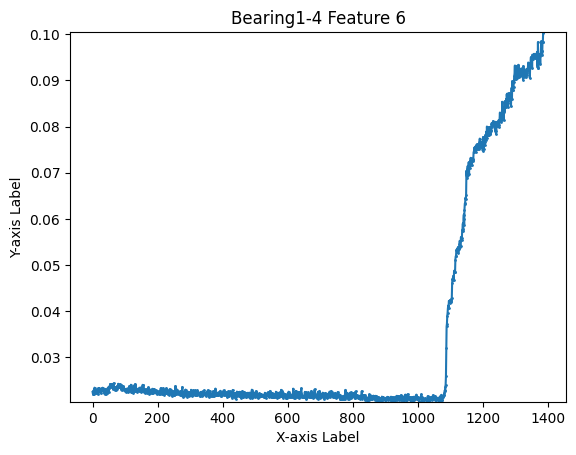

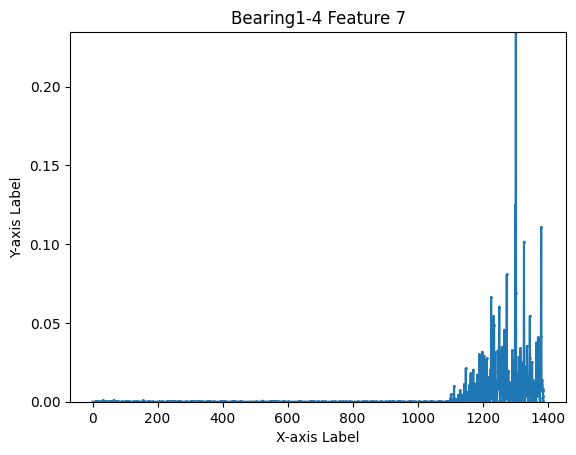

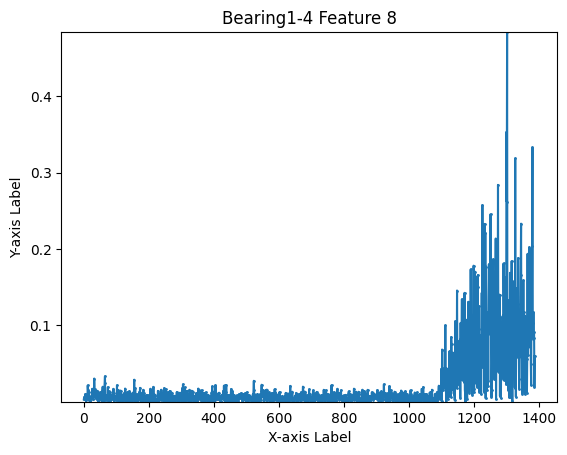

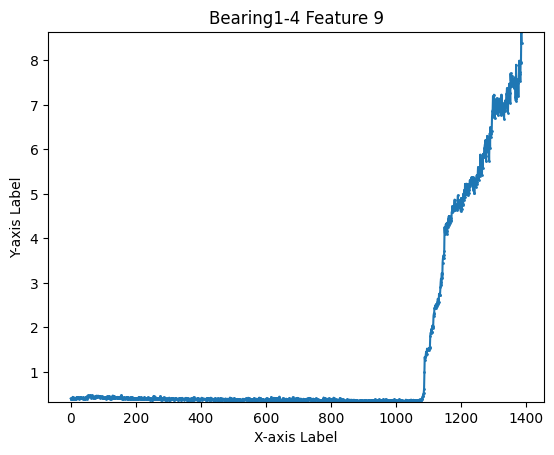

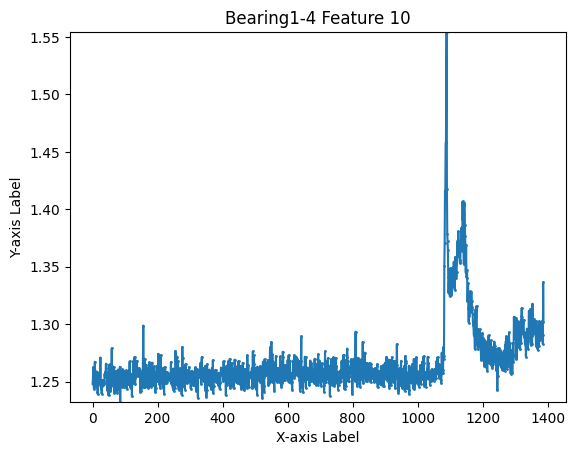

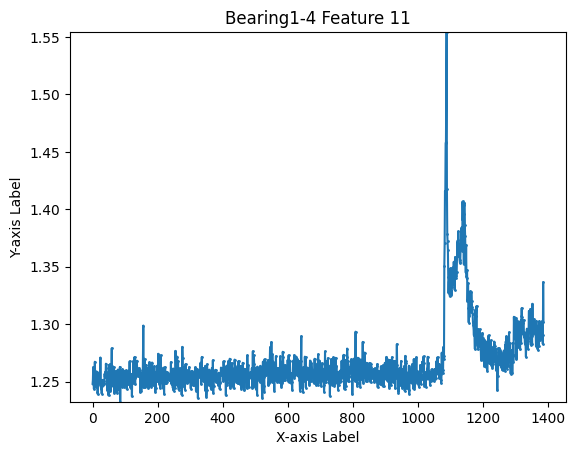

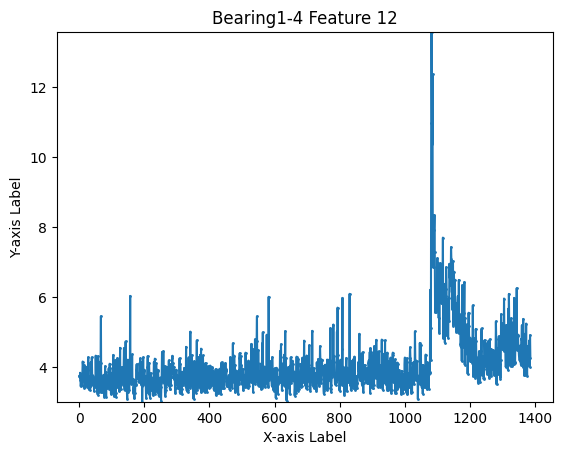

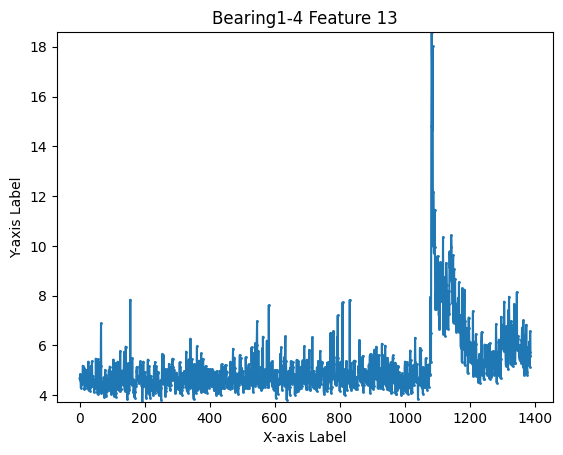

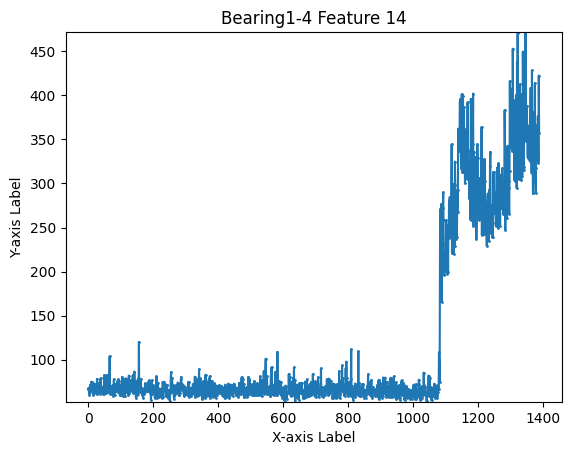

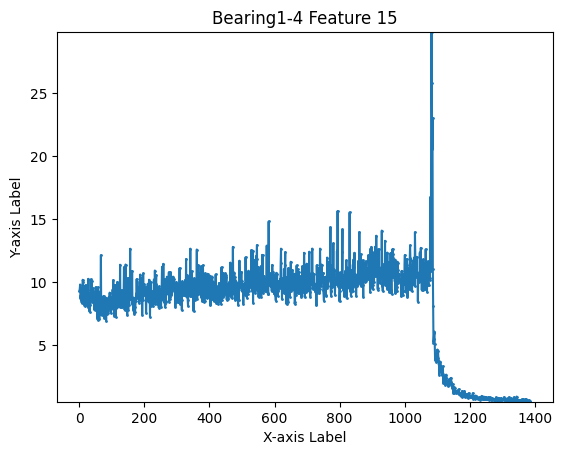

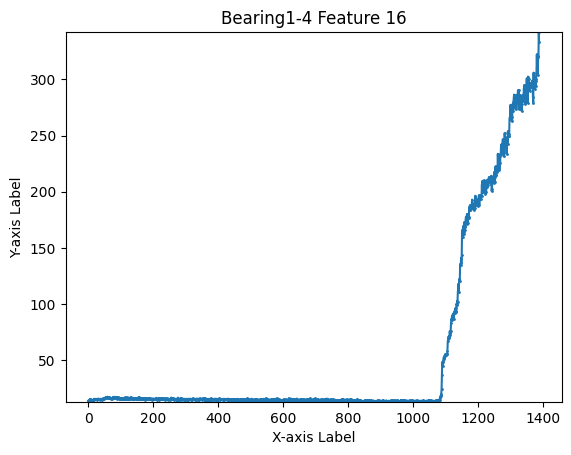

IndexError: index 16 is out of bounds for axis 2 with size 16

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_3[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_3[:, 0, i]), max(X_train_3[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-4 Feature {i+1}')
    # Display the plot
    plt.show()

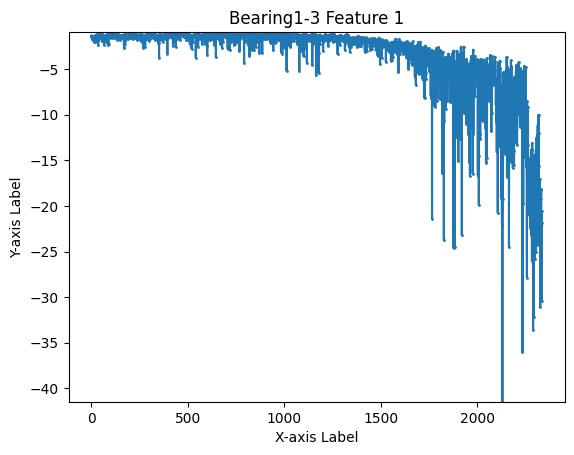

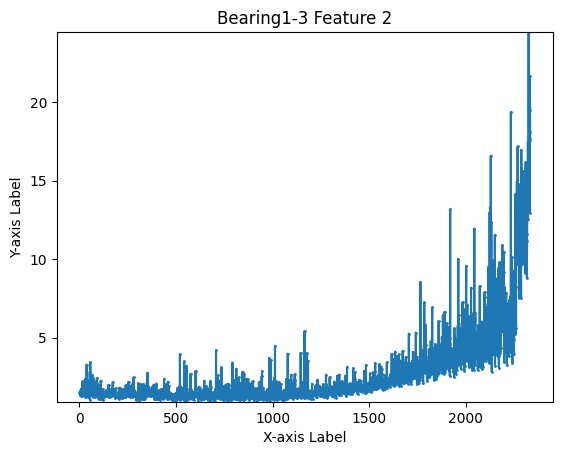

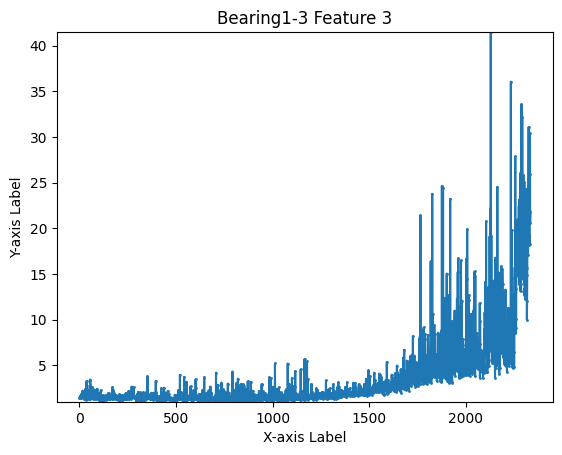

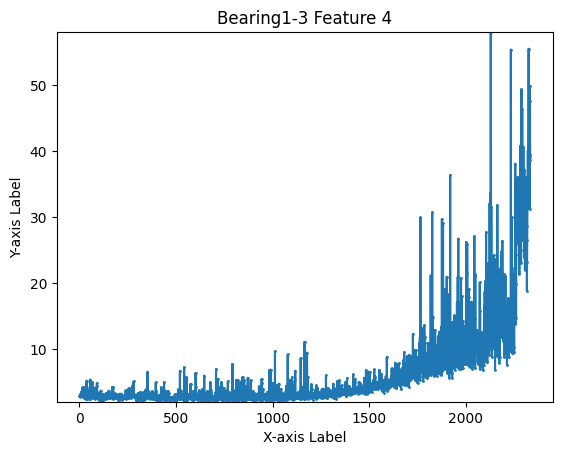

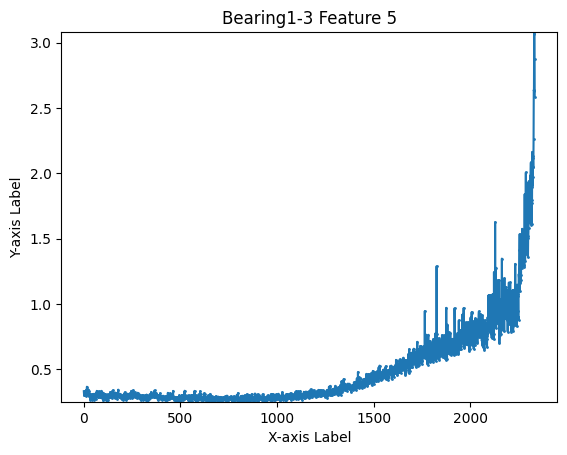

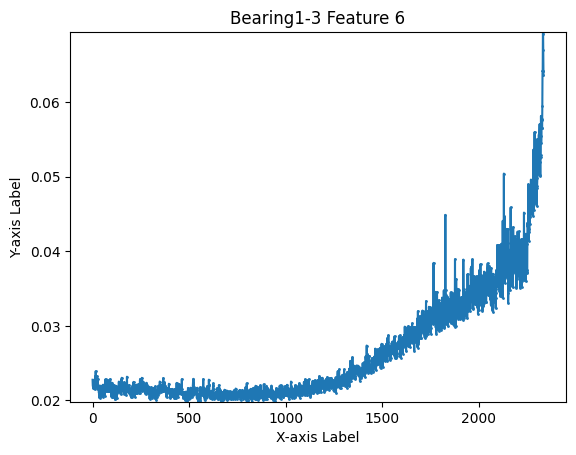

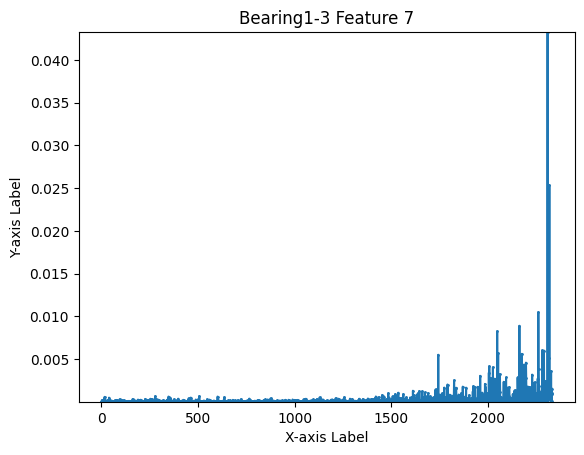

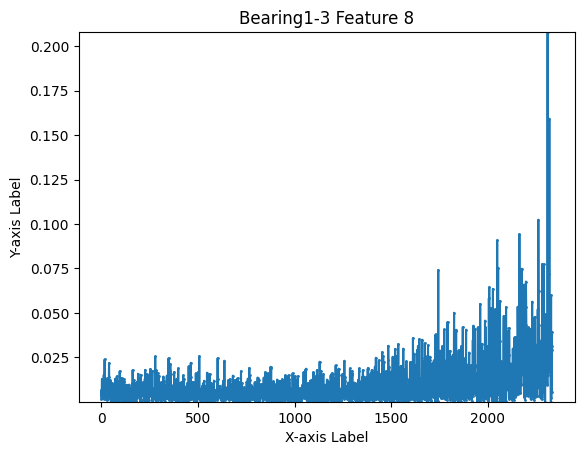

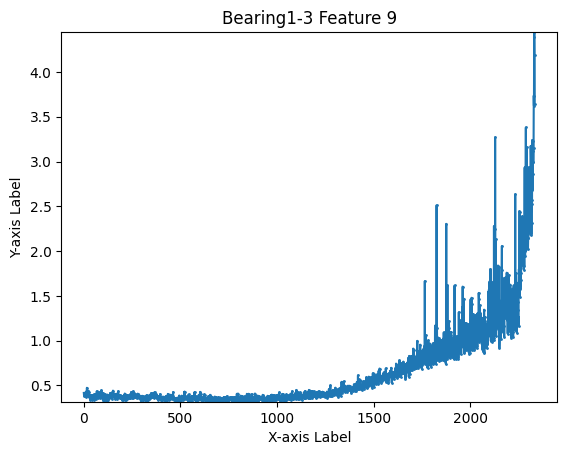

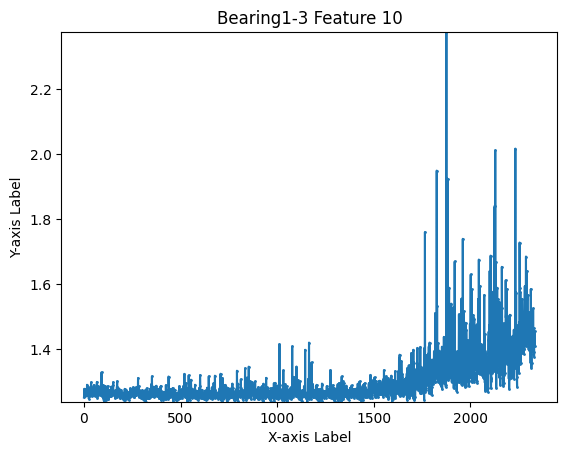

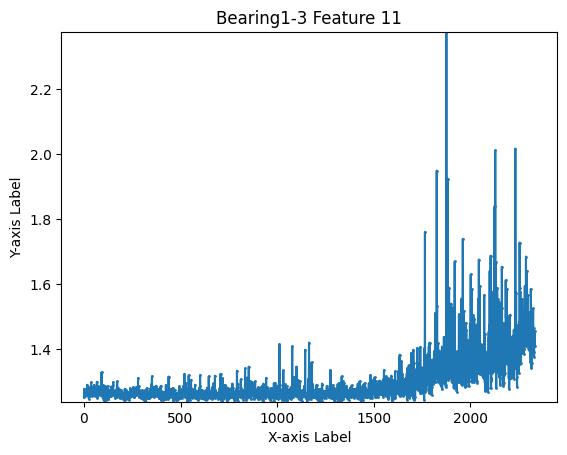

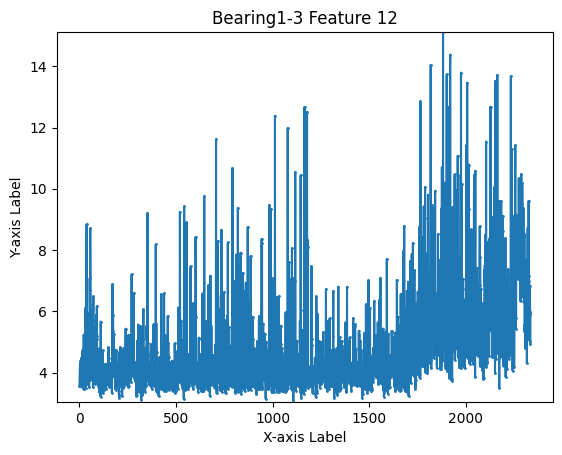

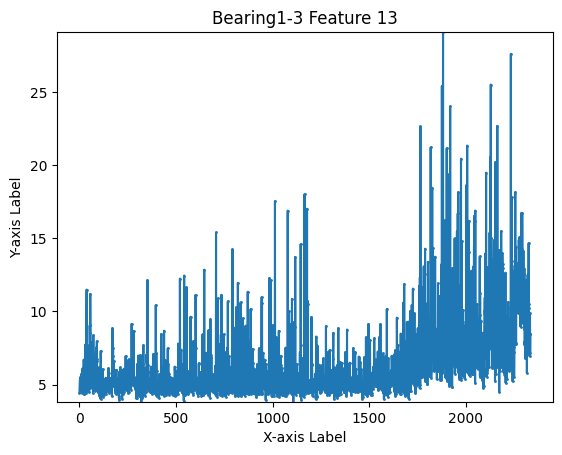

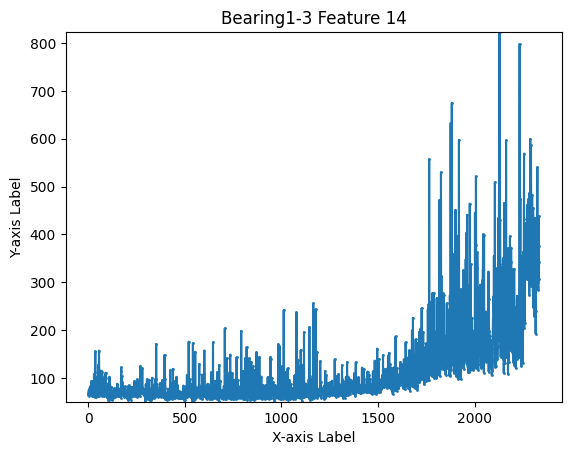

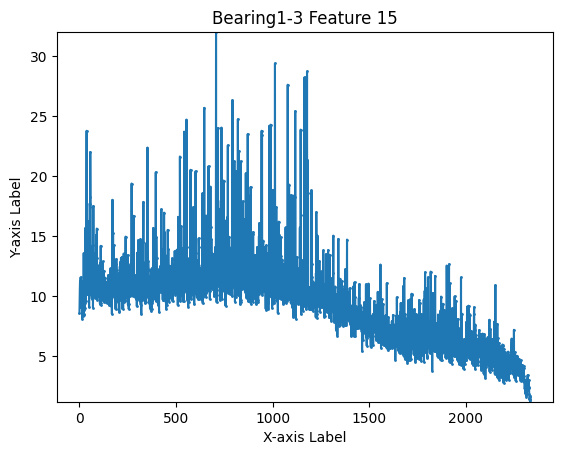

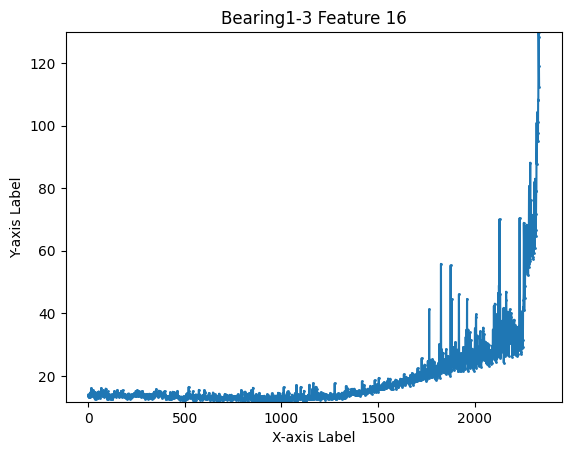

IndexError: index 16 is out of bounds for axis 2 with size 16

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_test[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_test[:, 0, i]), max(X_test[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-3 Feature {i+1}')
    # Display the plot
    plt.show()